# Sentiment Analysis of characters of Treasure Island

## Load and Clean the Text

### Loading All the necessary libraries

In [1]:
# Standard Library Imports 
import re
import math
import random
from collections import Counter

# Data Handling & Visualization 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries 
import nltk
import spacy
import coreferee
from nltk.tokenize import sent_tokenize, word_tokenize

# Web Requests
import requests

# Jupyter Notebook Setup
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


### Remove unwanted parts (like copyright boilerplates). Keeping only the main narrative.

In [2]:
# Load and clean the text
with open("treasure_island.txt", "r", encoding="utf-8") as f:
    text = f.read()

start_marker = "PART ONE--The Old Buccaneer"
end_marker = "*** END OF THE PROJECT GUTENBERG EBOOK TREASURE ISLAND ***"

start = text.find(start_marker)
end = text.find(end_marker)
cleaned_text = text[start:end]

with open("cleaned_treasure_island.txt", "w", encoding="utf-8") as f:
    f.write(cleaned_text)

print(f"Length of cleaned text: {len(cleaned_text):,} characters")

Length of cleaned text: 368,233 characters


In [3]:
# Show top of the cleaned text
print("***First 1000 characters of cleaned text:***\n")
print(cleaned_text[:1000])

# Divider
print("\n" + "="*80 + "\n")

# Show end of the cleaned text
print("***Last 1000 characters of cleaned text:***\n")
print(cleaned_text[-1000:])


***First 1000 characters of cleaned text:***

PART ONE--The Old Buccaneer









I

The Old Sea-dog at the Admiral Benbow





Squire Trelawney, Dr. Livesey, and the rest of these gentlemen having

asked me to write down the whole particulars about Treasure Island, from

the beginning to the end, keeping nothing back but the bearings of the

island, and that only because there is still treasure not yet lifted, I

take up my pen in the year of grace 17—, and go back to the time when

my father kept the Admiral Benbow inn and the brown old seaman with the

sabre cut first took up his lodging under our roof.



I remember him as if it were yesterday, as he came plodding to the

inn door, his sea-chest following behind him in a hand-barrow--a

tall, strong, heavy, nut-brown man, his tarry pigtail falling over the

shoulder of his soiled blue coat, his hands ragged and scarred, with

black, broken nails, and the sabre cut across one cheek, a dirty, livid

white. I remember him looking rou

## Text Segmentation and Sentence Tokenization

### Chapter Segmentation Using Regular Expressions

Gutenberg books often use double newlines and chapter numerals.

The regex captures those transitions without breaking on sentences or headings that just happen to contain Roman numerals.

In [4]:
# Chapter Segmentation
def split_chapters(text):
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    chapter_starts = list(re.finditer(r'\n+[IVXLCDM]+\n.*?\n', text))
    chapters = []
    for i in range(len(chapter_starts)):
        start_pos = chapter_starts[i].start()
        end_pos = chapter_starts[i + 1].start() if i + 1 < len(chapter_starts) else len(text)
        chapter_text = text[start_pos:end_pos].strip()
        match = re.match(r'\n*([IVXLCDM]+)\n(.*?)\n(.*)', chapter_text, re.DOTALL)
        if match:
            num = match.group(1)
            title = match.group(2).strip()
            content = match.group(3).strip()
            if len(content) > 50:
                chapters.append(f"{num}\n{title}\n\n{content}")
    return chapters

chapters = split_chapters(cleaned_text)

# Show chapter numbers and titles
for i, chap in enumerate(chapters):
    lines = chap.split('\n')
    print(f"Chapter {lines[0]}: {lines[1]}")


Chapter I: 
Chapter II: 
Chapter III: 
Chapter IV: 
Chapter V: 
Chapter VI: 
Chapter VII: 
Chapter VIII: 
Chapter IX: 
Chapter X: 
Chapter XI: 
Chapter XII: 
Chapter XIII: 
Chapter XIV: 
Chapter XV: 
Chapter XVI: 
Chapter XXVII: 
Chapter XVIII: 
Chapter XIX: 
Chapter XX: 
Chapter XXI: 
Chapter XXII: 
Chapter XXIII: 
Chapter XXIV: 
Chapter XXV: 
Chapter XXVI: 
Chapter XXVII: 
Chapter XXVIII: 
Chapter XXIX: 
Chapter XXX: 
Chapter XXXI: 
Chapter XXXII: 
Chapter XXXIII: 
Chapter XXXIV: 


In [5]:
# Coreference Resolution
nlp = spacy.load("en_core_web_trf")
nlp.add_pipe("coreferee")


def resolve_coref(text):
    doc = nlp(text)
    resolved = text
    if doc._.coref_chains:
        replacements = []
        for chain in doc._.coref_chains:
            main = doc[chain[0].token_indexes[0]:chain[0].token_indexes[-1] + 1].text
            for mention in chain[1:]:
                mention_text = doc[mention.token_indexes[0]:mention.token_indexes[-1] + 1].text
                if mention_text.lower() != main.lower():
                    replacements.append((mention_text, main))
        for mention_text, main in sorted(set(replacements), key=lambda x: -len(x[0])):
            mention_pattern = r'(?<!\w)' + re.escape(mention_text) + r'(?!\w)'
            resolved = re.sub(mention_pattern, main, resolved)
    return resolved

resolved_chapters = [resolve_coref(chap) for chap in chapters]

### Sentence Tokenisation with spaCy

In [6]:
# Sentence Tokenization
chapter_data = []

for chap_index, (orig, resolved) in enumerate(zip(chapters, resolved_chapters)):
    doc_original = nlp(orig)
    doc_resolved = nlp(resolved)
    original_sentences = [sent.text.strip() for sent in doc_original.sents]
    resolved_sentences = [sent.text.replace('\n', ' ').strip() for sent in doc_resolved.sents]
    min_len = min(len(original_sentences), len(resolved_sentences))
    for i in range(min_len):
        chapter_data.append({
            "Chapter": chap_index + 1,
            "Original_Sentence": original_sentences[i],
            "Sentence": resolved_sentences[i]
        })

sent_df = pd.DataFrame(chapter_data)

In [7]:
# Pronoun Count Check
pronoun_pattern = r'\b(?:he|she|his|her|him|they|them|their|the boy|the man|the doctor|the cook|the captain)\b'
count_before = sum(sent_df["Original_Sentence"].str.contains(pronoun_pattern, case=False, regex=True))
count_after = sum(sent_df["Sentence"].str.contains(pronoun_pattern, case=False, regex=True))
print(f"Sentences with pronouns BEFORE coref: {count_before}")
print(f"Sentences with pronouns AFTER coref:  {count_after}")

Sentences with pronouns BEFORE coref: 1584
Sentences with pronouns AFTER coref:  282


## Named Entity Recognition (NER) and Character Mention Extraction

In [8]:
# Named Entity Recognition
all_mentions = []
for sentence in sent_df["Sentence"]:
    doc = nlp(sentence)
    for ent in doc.ents:
        if ent.label_ == "PERSON":
            cleaned = ent.text.lower().replace("'s", "").strip()
            all_mentions.append(cleaned)

mention_counts = Counter(all_mentions)
mention_df = pd.DataFrame(mention_counts.items(), columns=["Name", "Mentions"]).sort_values(by="Mentions", ascending=False)
print("Total unique PERSON mentions:", len(mention_df))
pd.set_option('display.max_rows', None)
print(mention_df)


Total unique PERSON mentions: 149
                      Name  Mentions
48                  silver       195
1                  livesey       155
9                      jim       139
57               trelawney       129
45                    john       104
74                    dick       100
86                    gunn        90
5                     bill        77
2                   benbow        66
56                     tom        46
16                   flint        43
40                  hunter        42
96                    gray        42
63                  morgan        41
80                   hands        41
10                 hawkins        40
131                  merry        38
68                anderson        36
88                ben gunn        35
65                smollett        34
125                    wot        31
124                 george        30
83                    alan        27
41                 redruth        24
49               long john        24
39  

###   Alias Mapping and Character Assignment

Characters list from "https://www.sparknotes.com/lit/treasure/characters/"

In [9]:

alias_to_canonical = {}
ner_merge_map = {
    "Jim Hawkins": [
        "jim", "hawkins", "jim hawkins", "james hawkins", "hawkin",
        "jim  hawkins", "jim hawkins’"
    ],
    "Long John Silver": [
        "silver", "long john", "john silver", "long john silver", "’s john silver", "john’s",
        "john  silver", "long john’s"
    ],
    "Dr. David Livesey": [
        "livesey", "livesey’s", "dr. livesey", "david livesey", "doctor livesey", "dr",
        "livesey--", "livesey shoulder", "livesey maker"
    ],
    "Squire Trelawney": [
        "trelawney", "squire trelawney", "john trelawney", "john      trelawney",
        "trelawney’s", "squire trelawney’s"
    ],
    "Captain Smollett": [
        "smollett", "alexander smollett", "alexander  smollett", "cap’n smollett", "smollett smollett"
    ],
    "Ben Gunn": [
        "ben gunn", "benjamin gunn", "ben gunn’s", "ben", "gunn", "--ben gunn’s",
        "ben  gunn", "ben gunn gunn", "ben  gunn’s"
    ],
    "Billy Bones": [
        "bill", "billy", "billy bones", "billy bones’s", "bones--", "w. bones",
        "billy  bones", "billy bones bill", "bill  lancet"
    ],
    "Captain Flint": [
        "flint"
    ],
    "George Merry": [
        "george merry", "george", "merry", "george  merry"
    ],
    "Israel Hands": [
        "israel hands"
    ],
    "Tom": [
        "tom"
    ],
    "Tom Morgan": [
        "tom morgan", "morgan"
    ],
    "Tom Redruth": [
        "tom redruth", "redruth", "thomas redruth", "redruth royal highness"
    ],
    "Hunter": [
        "hunter", "john hunter"
    ],
    "Joyce": [
        "joyce", "richard joyce"
    ],
    "Dick Johnson": [
        "dick", "dick’s", "dick johnson"
    ],
    "Job Anderson": [
        "anderson", "job anderson"
    ],
    "Abraham Gray": [
        "gray", "abraham gray", "abe gray", "abe gray--"
    ],
    "Alan": [
        "alan"
    ],
    "Dance": [
        "dance", "supervisor dance"
    ],
    "Arrow": [
        "arrow"
    ]
}


In [10]:

for canonical, aliases in ner_merge_map.items():
    for alias in sorted(aliases, key=lambda x: -len(x)):
        alias_to_canonical[alias.lower()] = canonical

def get_characters_from_sentence(sentence):
    characters_found = set()
    lower_sentence = sentence.lower()
    for alias, canonical in alias_to_canonical.items():
        alias_clean = re.escape(alias)
        if re.search(rf'(?<!\w){alias_clean}(?!\w)', lower_sentence):
            characters_found.add(canonical)
    return list(characters_found)

sent_df["Characters"] = sent_df["Sentence"].apply(get_characters_from_sentence)
print(sent_df[sent_df["Characters"].map(len) > 0].head(50))


     Chapter                                  Original_Sentence  \
0          1  I\n\n\nThe Old Sea-dog at the Admiral Benbow\n...   
18         1  The man who came\n\nwith the barrow told us th...   
27         1  For me, at least, there was no secret about th...   
55         1  The great sea-chest none of us had\n\never see...   
60         1  Suddenly he--the captain,\n\nthat is--began to...   
62         1  At first I had supposed “the dead man’s chest”...   
72         1  I’m not a doctor only; I’m a magistrate; and i...   
74         2  It was not very long after this that there occ...   
78         2  I\n\nremember his breath hanging like smoke in...   
79         2  He\n\nwas a pale, tallowy creature, wanting tw...   
81         2  He was not sailorly, and yet he had a\n\nsmack...   
83         2  as I was going out of the room to fetch it, he...   
84         2  I paused where I was, with my napkin in my\n\n...   
85         2                       “Come here, sonny,” says he

## Manual Role-Based Mapping and Remaining Ambiguities

Problems with stanza or any other ner like spicy are

They are not detecting roles which are used as a refernece to talk about characters.

so adding these missed entries of people manually.

"doctor", "dr. livesey" == Dr. David Livesey

"Israel" == "Israel Hands"

'Squire' == Squire Trelawney

'Cook' == Long John Silver

'blind man' = pew

'gamekeeper' = Tom Redruth

In [11]:
# Manual Role-Based Mapping
enriched_roles = {
    "doctor": "Dr. David Livesey",
    "dr. livesey": "Dr. David Livesey",
    "israel": "Israel Hands",
    "squire": "Squire Trelawney",
    "blind man": "Pew",
    "gamekeeper": "Tom Redruth"
}

manual_roles_map = {k.lower(): v for k, v in enriched_roles.items()}


def enrich_with_manual_roles(sentence, existing_characters):
    updated_characters = set(existing_characters)
    lower_sentence = sentence.lower()
    for role, canonical in manual_roles_map.items():
        if re.search(rf'(?<!\w){re.escape(role)}(?!\w)', lower_sentence):
            updated_characters.add(canonical)
    return list(updated_characters)

sent_df["Characters"] = sent_df.apply(
    lambda row: enrich_with_manual_roles(row["Sentence"], row["Characters"]), axis=1
)

print(sent_df[sent_df["Characters"].map(len) > 0].head(50))


     Chapter                                  Original_Sentence  \
0          1  I\n\n\nThe Old Sea-dog at the Admiral Benbow\n...   
18         1  The man who came\n\nwith the barrow told us th...   
27         1  For me, at least, there was no secret about th...   
55         1  The great sea-chest none of us had\n\never see...   
56         1                                                      
60         1  Suddenly he--the captain,\n\nthat is--began to...   
62         1  At first I had supposed “the dead man’s chest”...   
63         1  But by this\n\ntime we had all long ceased to ...   
65         1  The voices\n\nstopped at once, all but Dr. Liv...   
68         1  He sprang to his feet, drew and opened\n\na sa...   
69         1  He spoke to him as before, over his\n\nshoulde...   
72         1  I’m not a doctor only; I’m a magistrate; and i...   
74         2  It was not very long after this that there occ...   
75         2  It was a bitter cold winter, with long, hard\n..

### Manual aliasing for "captain" and "tom" and "cook" and "hands"


Different cases...

'Captain' == ?? Smollett, Silver, Bones, or Flint? ---> there are three people who were captains along the story so people say captain it is hard to point who is whom.

'Tom' == ?? Tom, Tom Morgan, Tom Redruth ---> three different people with same name.

## Using quote attribution of coreferee and dependency parsing of spacy.

In [12]:
# Quote Attribution
quote_pattern = re.compile(r'“([^”]+)”\s*(?:said|replied|cried|asked|muttered|shouted)\s+([A-Z][a-z]+)', re.IGNORECASE)

def extract_quote_attributions(sentence):
    matches = quote_pattern.findall(sentence)
    return matches if matches else []

sent_df["Quotes"] = sent_df["Original_Sentence"].apply(extract_quote_attributions)

# Dependency-Based Sentiment Target Extraction
def extract_sentiment_targets(doc):
    sentiments = []
    for token in doc:
        # e.g. "Jim is brave" (brave → adj, Jim → nsubj)
        if token.dep_ in ("nsubj", "nsubjpass") and token.head.pos_ == "ADJ":
            sentiments.append((token.text, token.head.text))
        # e.g. "brave Jim" (amod = adjective modifier of PERSON)
        elif token.dep_ == "amod" and token.head.ent_type_ == "PERSON":
            sentiments.append((token.head.text, token.text))
    return sentiments

sent_df["Sentiment_Targets"] = sent_df["Sentence"].apply(lambda x: extract_sentiment_targets(nlp(x)))


## Sentiment Analysis

### Setting Up Vader

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

# Sentiment from Quotes
def sentiment_from_quotes(quotes_list):
    results = []
    for quote, speaker in quotes_list:
        score = analyzer.polarity_scores(quote)["compound"]
        speaker_lower = speaker.strip().lower()
        if speaker_lower in alias_to_canonical:
            canonical = alias_to_canonical[speaker_lower]
            results.append((canonical, score))
    return results

sent_df["Quote_Sentiments"] = sent_df["Quotes"].apply(sentiment_from_quotes)

# Sentiment from Dependency Targets
def sentiment_from_dependencies(dep_targets):
    results = []
    for character, descriptor in dep_targets:
        if not descriptor:
            continue
        phrase = f"{character.strip()} {descriptor.strip()}"
        score = analyzer.polarity_scores(phrase)["compound"]
        character_lower = character.strip().lower()
        if character_lower in alias_to_canonical:
            canonical = alias_to_canonical[character_lower]
            results.append((canonical, score))
    return results

sent_df["Dependency_Sentiments"] = sent_df["Sentiment_Targets"].apply(sentiment_from_dependencies)

# Combine both
def combine_all_sentiments(row):
    combined = []
    if row["Quote_Sentiments"]:
        combined.extend(row["Quote_Sentiments"])
    if row["Dependency_Sentiments"]:
        combined.extend(row["Dependency_Sentiments"])
    return combined if combined else None

sent_df["Character_Sentiments"] = sent_df.apply(combine_all_sentiments, axis=1)


### Assigning Sentiment to Sentences

In [14]:
# Assign VADER sentiment score to each sentence
sent_df["SentimentScore"] = sent_df["Sentence"].apply(lambda s: analyzer.polarity_scores(s)["compound"])

# View top rows
print(sent_df[["Sentence", "SentimentScore"]].head(10))

# If no character-specific sentiment, assign sentence score to all characters mentioned
def fallback_character_sentiments(row):
    if row["Character_Sentiments"]:
        return row["Character_Sentiments"]
    elif row["Characters"]:
        return [(char, row["SentimentScore"]) for char in row["Characters"]]
    else:
        return None

sent_df["Final_Character_Sentiments"] = sent_df.apply(fallback_character_sentiments, axis=1)


                                            Sentence  SentimentScore
0  I   The Old Sea-dog at the Admiral Benbow     ...          0.8422
1  I remember Benbow as if notice were yesterday,...         -0.8360
2  I remember Benbow looking round the cove and w...         -0.8268
3  Then pen rapped on the door with a bit of  sti...          0.3612
4  This, when notice was brought to Benbow,  pen ...          0.3612
5  “This is a handy cove,” says pen at length; “a...          0.5106
6                               Much company, mate?”          0.0000
7  My father told Benbow no, very little company,...         -0.3535
8  “Well, then,” said pen, “this is the berth for...          0.0000
9  Here you, matey,” pen  cried to the Benbow who...          0.0258


### Mapping Sentiment to Characters

In [15]:
# Only assign sentiment when it directly applies to the character
rows = []
for _, row in sent_df.iterrows():
    if row["Final_Character_Sentiments"]:
        for character, score in row["Final_Character_Sentiments"]:
            rows.append({
                "Character": character,
                "Sentence": row["Sentence"],
                "SentimentScore": score,
                "Chapter": row["Chapter"]
            })

long_df = pd.DataFrame(rows)

### Major and Minor Characters.

In [16]:
# CHARACTER IMPORTANCE BY MENTION FREQUENCY
character_mentions = long_df["Character"].value_counts().reset_index()
character_mentions.columns = ["Character", "MentionCount"]
character_mentions = character_mentions.sort_values("MentionCount", ascending=False)

# Categorize characters
major_threshold = 100
character_mentions["Category"] = character_mentions["MentionCount"].apply(
    lambda x: "Major" if x >= major_threshold else "Minor"
)

# Split into major and minor
major_characters = character_mentions[character_mentions["Category"] == "Major"].copy()
minor_characters = character_mentions[character_mentions["Category"] == "Minor"].copy()

# Reset index to start from 1
major_characters.index = range(1, len(major_characters) + 1)
minor_characters.index = range(1, len(minor_characters) + 1)

# Display as copyable tables
display(major_characters.style.set_caption("Major Characters by Mentions"))
display(minor_characters.style.set_caption("Minor Characters by Mentions"))


,Character,MentionCount,Category
1,Long John Silver,313,Major
2,Dr. David Livesey,273,Major
3,Squire Trelawney,255,Major
4,Jim Hawkins,174,Major
5,Ben Gunn,123,Major


,Character,MentionCount,Category
1,Dick Johnson,86,Minor
2,George Merry,82,Minor
3,Captain Flint,80,Minor
4,Billy Bones,70,Minor
5,Tom,49,Minor
6,Tom Morgan,48,Minor
7,Hunter,45,Minor
8,Captain Smollett,45,Minor
9,Abraham Gray,44,Minor
10,Job Anderson,37,Minor


## Character Sentiment Summary

In [17]:
# Add Median and Quartiles
summary_stats = (
    long_df
    .groupby("Character")
    .agg(
        TotalMentions=("Sentence", "count"),
        AvgSentiment=("SentimentScore", "mean"),
        MedianSentiment=("SentimentScore", "median"),
        Q1Sentiment=("SentimentScore", lambda x: x.quantile(0.25)),
        Q3Sentiment=("SentimentScore", lambda x: x.quantile(0.75)),
        MaxSentiment=("SentimentScore", "max"),
        MinSentiment=("SentimentScore", "min")
    )
    .reset_index()
    .sort_values("TotalMentions", ascending=False)
)

# Display index from 1 (for viewing only)
summary_stats.index = pd.Index(range(1, len(summary_stats) + 1), name="#")

# Save (without index) for later use
summary_stats.to_csv("character_sentiment_summary.csv", index=False)

# Display styled summary table
styled_table = summary_stats.style.set_table_styles([
    {'selector': 'th', 'props': [('background-color', 'white'), ('color', 'black')]},
    {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse')]}
]).set_properties(**{'border': '1px solid #ddd', 'padding': '4px'})

styled_table


,Character,TotalMentions,AvgSentiment,MedianSentiment,Q1Sentiment,Q3Sentiment,MaxSentiment,MinSentiment
#,,,,,,,,
1,Long John Silver,313,0.075871,0.000000,-0.077200,0.361200,0.922400,-0.938200
2,Dr. David Livesey,273,0.064778,0.000000,-0.102700,0.381800,0.953900,-0.980400
3,Squire Trelawney,255,0.098098,0.000000,0.000000,0.401900,0.953100,-0.923100
4,Jim Hawkins,174,0.070010,0.000000,0.000000,0.396875,0.922400,-0.921700
5,Ben Gunn,123,0.125625,0.000000,0.000000,0.417900,0.960700,-0.904200
6,Dick Johnson,86,-0.269477,-0.296000,-0.567975,0.000000,0.836500,-0.962300
7,George Merry,82,0.326466,0.457850,0.000000,0.630775,0.934800,-0.898600
8,Captain Flint,80,0.045819,0.000000,-0.019300,0.319900,0.888500,-0.895700
9,Billy Bones,70,0.038476,0.000000,0.000000,0.296000,0.914500,-0.928200


## Sentiment Arcs per Character

In [18]:
sentiment_by_chapter_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .mean()
    .reset_index()
    .rename(columns={"SentimentScore": "AvgSentiment"})
)

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_character_sentiment_arcs(
    sentiment_df,
    character_df,
    category_label="Major",
    top_n=4,
    cols=1,
    smooth=True,
    annotate_spikes=True,
    gap_threshold=5,  # Max allowed chapter gap to connect
    chapter_ticks=[1, 5, 10, 15, 20, 25, 30, 34]
):
    # --- Fix column names if necessary ---
    if "MentionCount" not in character_df.columns:
        if "Mention Count" in character_df.columns:
            character_df = character_df.rename(columns={"Mention Count": "MentionCount"})
        else:
            raise ValueError("character_df must contain 'MentionCount' or 'Mention Count' column.")

    # --- Sort and pick top characters ---
    character_df = character_df.sort_values("MentionCount", ascending=False).head(top_n)
    character_list = character_df["Character"].tolist()
    mention_map = dict(zip(character_df["Character"], character_df["MentionCount"]))

    rows = top_n  # for single-column layout
    fig, axes = plt.subplots(rows, cols, figsize=(8.27, 11.69))  # A4 portrait size
    axes = axes.flatten()

    for idx, character in enumerate(character_list):
        ax = axes[idx]
        char_data = sentiment_df[sentiment_df["Character"] == character].sort_values("Chapter").copy()

        # Replace sentiment with NaN if no mentions
        if "MentionCount" in char_data.columns:
            char_data.loc[char_data["MentionCount"] == 0, "AvgSentiment"] = np.nan

        # Smooth if enabled
        if smooth:
            char_data["SmoothedSentiment"] = char_data["AvgSentiment"].rolling(window=2, min_periods=1).mean()
            y_vals = char_data["SmoothedSentiment"]
        else:
            y_vals = char_data["AvgSentiment"]

        color = 'blue' if y_vals.mean(skipna=True) >= 0 else 'red'

        # --- Gap-breaking logic ---
        x_vals = char_data["Chapter"].to_numpy()
        y_array = y_vals.to_numpy()

        # Break into segments if gap > threshold
        segments_x, segments_y = [], []
        current_x, current_y = [x_vals[0]], [y_array[0]]

        for i in range(1, len(x_vals)):
            if np.isnan(y_array[i]) or np.isnan(current_y[-1]) or abs(x_vals[i] - current_x[-1]) > gap_threshold:
                # Store segment
                segments_x.append(current_x)
                segments_y.append(current_y)
                current_x, current_y = [x_vals[i]], [y_array[i]]
            else:
                current_x.append(x_vals[i])
                current_y.append(y_array[i])

        segments_x.append(current_x)
        segments_y.append(current_y)

        # Plot each segment
        for sx, sy in zip(segments_x, segments_y):
            if len(sx) > 1:
                ax.plot(sx, sy, marker='o', linestyle='-', color=color)

        # Annotate spikes
        if annotate_spikes and y_vals.notna().any():
            try:
                max_row = char_data.loc[y_vals.idxmax()]
                min_row = char_data.loc[y_vals.idxmin()]
                ax.annotate(f"{max_row['Chapter']}", xy=(max_row["Chapter"], max_row[y_vals.name]),
                            xytext=(0, 6), textcoords='offset points', fontsize=10, ha='center', color='green')
                ax.annotate(f"{min_row['Chapter']}", xy=(min_row["Chapter"], min_row[y_vals.name]),
                            xytext=(0, -10), textcoords='offset points', fontsize=10, ha='center', color='red')
            except:
                pass

        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax.set_title(f"{character} ({mention_map[character]})", fontsize=13)
        ax.set_xlabel("Chapter", fontsize=12)
        ax.set_ylabel("Sentiment", fontsize=12)
        ax.set_xticks(chapter_ticks)
        ax.tick_params(axis='both', labelsize=11)
        ax.grid(True)

    # Turn off unused subplots
    for j in range(len(character_list), len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Top four {category_label} Characters – Sentiment Arcs", fontsize=16)
    fig.subplots_adjust(left=0.1, right=0.95, top=0.93, bottom=0.05, hspace=0.5)
    plt.show()


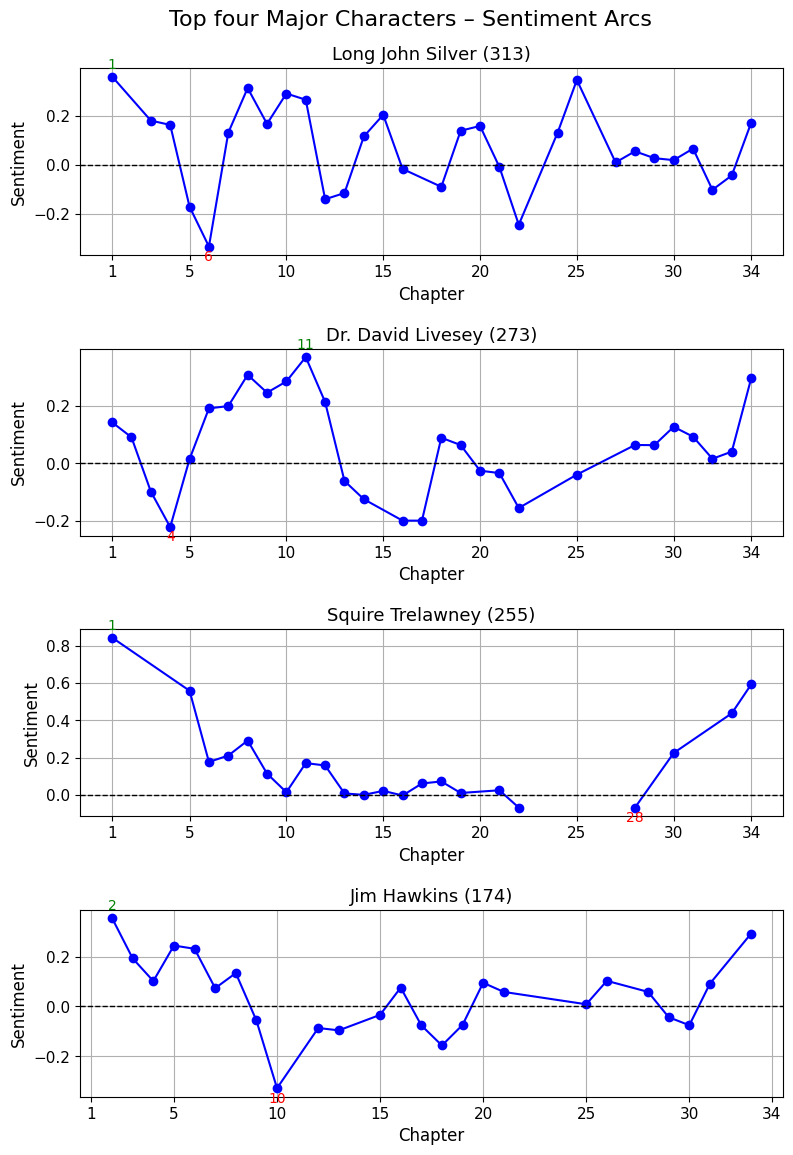

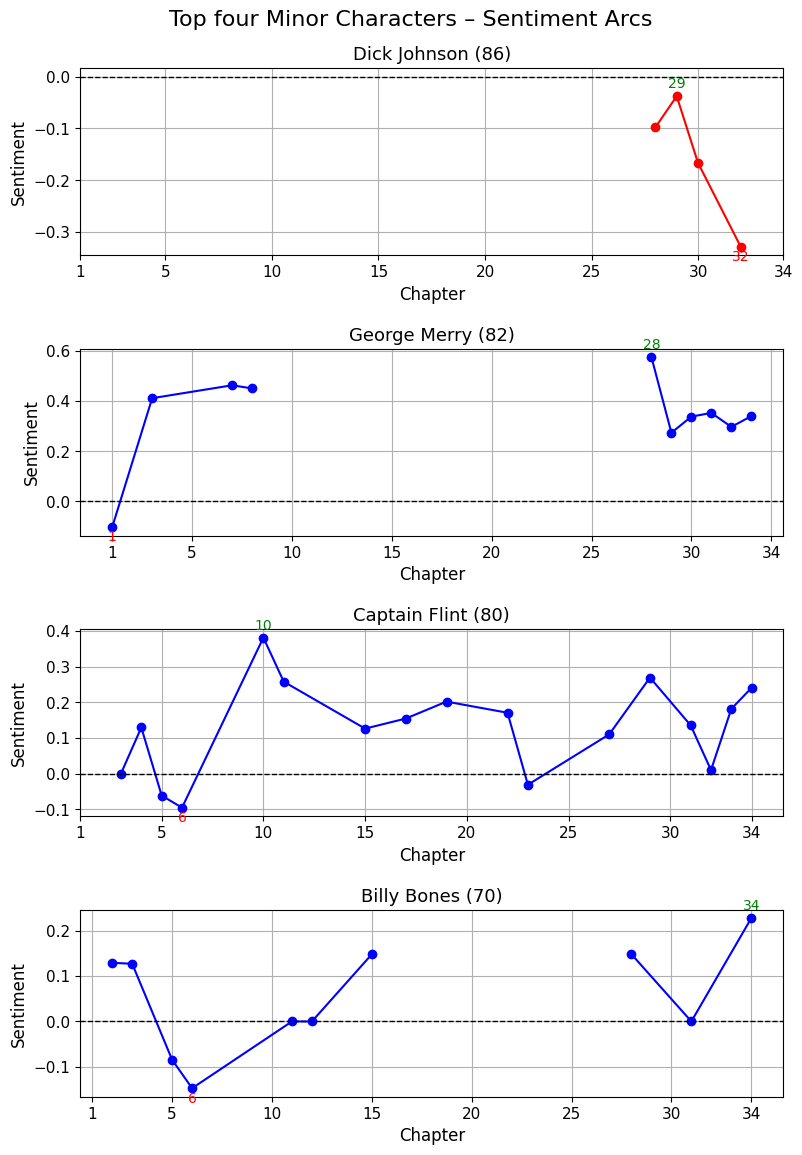

In [20]:
plot_character_sentiment_arcs(sentiment_by_chapter_df, major_characters, category_label="Major", top_n=4) # type: ignore
plot_character_sentiment_arcs(sentiment_by_chapter_df, minor_characters, category_label="Minor", top_n=4) # type: ignore


## Sentiment Volatility by Character

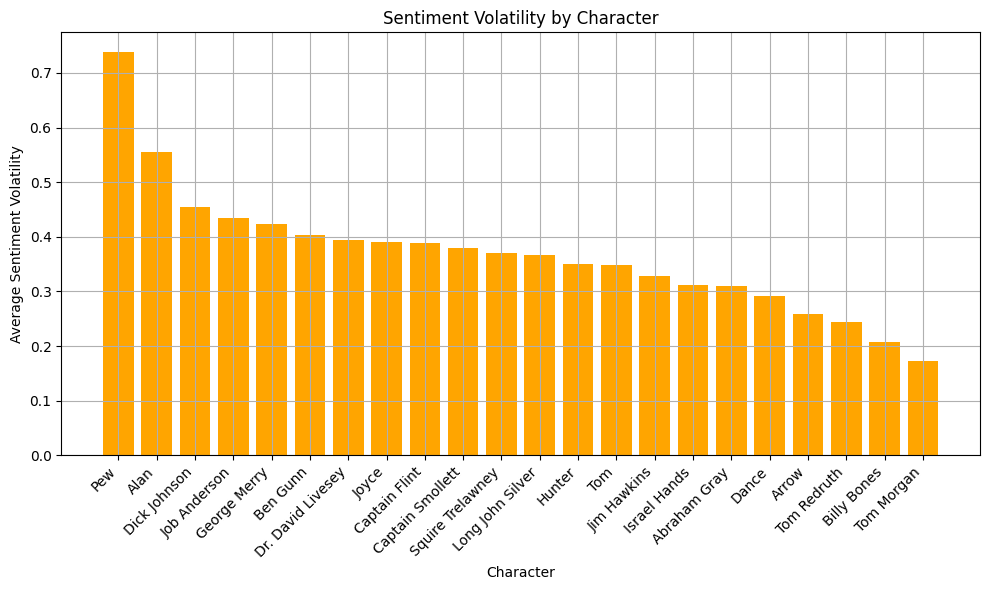

In [21]:

# Calculate sentiment volatility (standard deviation of sentiment per chapter for each character)
sentiment_volatility_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .std()  # Calculate standard deviation for each character per chapter
    .reset_index()
    .rename(columns={"SentimentScore": "SentimentVolatility"})
)

# Calculate the average sentiment volatility for each character across all chapters
average_volatility = sentiment_volatility_df.groupby("Character")["SentimentVolatility"].mean().reset_index()

# Sort characters by sentiment volatility (high to low)
sorted_volatility = average_volatility.sort_values("SentimentVolatility", ascending=False)

# Plot sentiment volatility for each character
plt.figure(figsize=(10, 6))

# Create a bar plot to visualize sentiment volatility for the top characters
plt.bar(sorted_volatility["Character"], sorted_volatility["SentimentVolatility"], color='orange')
plt.title('Sentiment Volatility by Character')
plt.xlabel('Character')
plt.ylabel('Average Sentiment Volatility')
plt.xticks(rotation=45, ha="right")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


## Hero & Villain Analysis

In [22]:
from scipy.stats import gaussian_kde
import numpy as np
## Hero & Villain Analysis
# Ensure 'character_mentions' is built correctly
character_mentions = long_df["Character"].value_counts().reset_index()
character_mentions.columns = ["Character", "MentionCount"]

# Calculate average sentiment
avg_sentiment = long_df.groupby("Character")["SentimentScore"].mean().reset_index()

# Calculate average volatility (std dev per character)
sentiment_volatility_df = (
    long_df.groupby(["Character", "Chapter"])["SentimentScore"]
    .std()
    .reset_index()
    .rename(columns={"SentimentScore": "SentimentVolatility"})
)
average_volatility = sentiment_volatility_df.groupby("Character")["SentimentVolatility"].mean().reset_index()

# Merge everything
role_df = avg_sentiment.merge(average_volatility, on="Character")
role_df = role_df.merge(character_mentions, on="Character")
role_df = role_df.rename(columns={
    "SentimentScore": "AvgSentiment",
    "SentimentVolatility": "SentimentStdDev",
    "MentionCount": "TotalMentions"
})


# --- thresholds ---
DELTA = 0.10
EPS    = DELTA / 2.0        # use for square width on sentiment (0.05)
SUP_X  = EPS                # half-width of support square on x (AvgSentiment)
SUP_Y  = EPS                # half-height of support square on y (StdDev) -> change if you want a thinner square

# --- volatility split (KDE mode) ---
_data  = role_df["SentimentStdDev"].dropna().values
_kde   = gaussian_kde(_data)
_grid  = np.linspace(_data.min(), _data.max(), 1000)
VSTAR  = _grid[np.argmax(_kde(_grid))]

print(f"Using thresholds -> DELTA={DELTA:.2f}, EPS={EPS:.2f}, VSTAR={VSTAR:.4f}, SUP_X={SUP_X:.3f}, SUP_Y={SUP_Y:.3f}")

def infer_role_square(row, vstar=VSTAR, delta=DELTA, sup_x=SUP_X, sup_y=SUP_Y):
    s = row["AvgSentiment"]
    v = row["SentimentStdDev"]

    # 1) Center SQUARE = Support/Neutral (visual == logic)
    if abs(s) <= sup_x and abs(v - vstar) <= sup_y:
        return "Support/Neutral"

    # 2) Outside the square:
    #    Low volatility side
    if v < vstar:
        return "Hero" if s >= 0 else "Villain"

    #    High volatility side
    if s <= -delta:
        return "Villain"          # strongly negative & volatile
    else:
        return "Morally Complex"  # positive or mildly negative & volatile

role_df = role_df.copy()
role_df["RefinedRole"] = role_df.apply(infer_role_square, axis=1)

# view table
role_df = role_df.sort_values("TotalMentions", ascending=False).reset_index(drop=True)
print(role_df[["Character","TotalMentions","AvgSentiment","SentimentStdDev","RefinedRole"]].to_string(index=False))

Using thresholds -> DELTA=0.10, EPS=0.05, VSTAR=0.3667, SUP_X=0.050, SUP_Y=0.050
        Character  TotalMentions  AvgSentiment  SentimentStdDev     RefinedRole
 Long John Silver            313      0.075871         0.367267 Morally Complex
Dr. David Livesey            273      0.064778         0.394733 Morally Complex
 Squire Trelawney            255      0.098098         0.371026 Morally Complex
      Jim Hawkins            174      0.070010         0.329005            Hero
         Ben Gunn            123      0.125625         0.403274 Morally Complex
     Dick Johnson             86     -0.269477         0.453865         Villain
     George Merry             82      0.326466         0.422578 Morally Complex
    Captain Flint             80      0.045819         0.388725 Support/Neutral
      Billy Bones             70      0.038476         0.207094            Hero
              Tom             49      0.109173         0.348576            Hero
       Tom Morgan             48      0

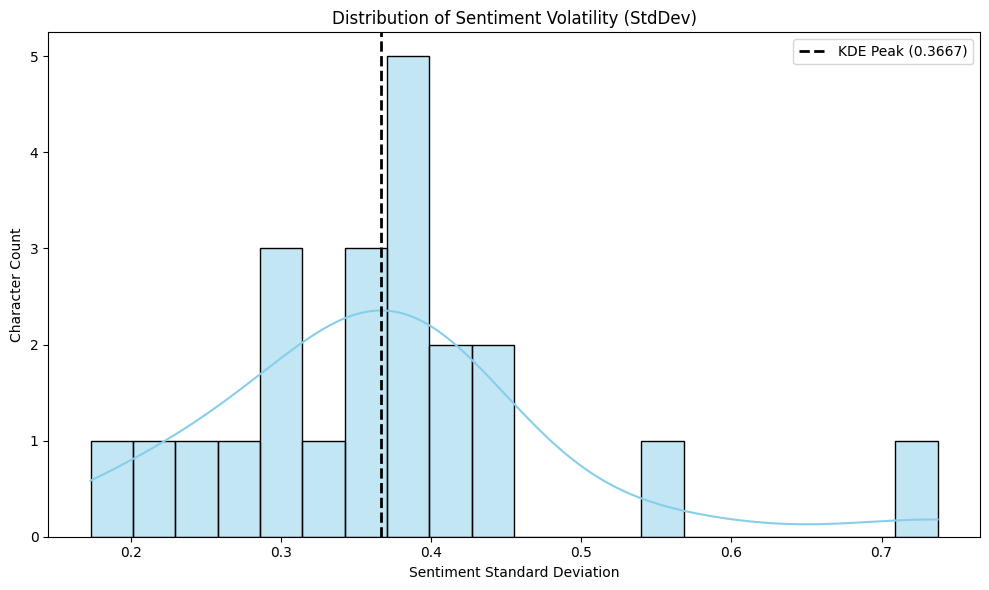

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(_data, kde=True, bins=20, color='skyblue')
plt.axvline(VSTAR, color='black', linestyle='--', linewidth=2, label=f"KDE Peak ({VSTAR:.4f})")
plt.title("Distribution of Sentiment Volatility (StdDev)")
plt.xlabel("Sentiment Standard Deviation"); plt.ylabel("Character Count")
plt.legend(); plt.tight_layout(); plt.show()


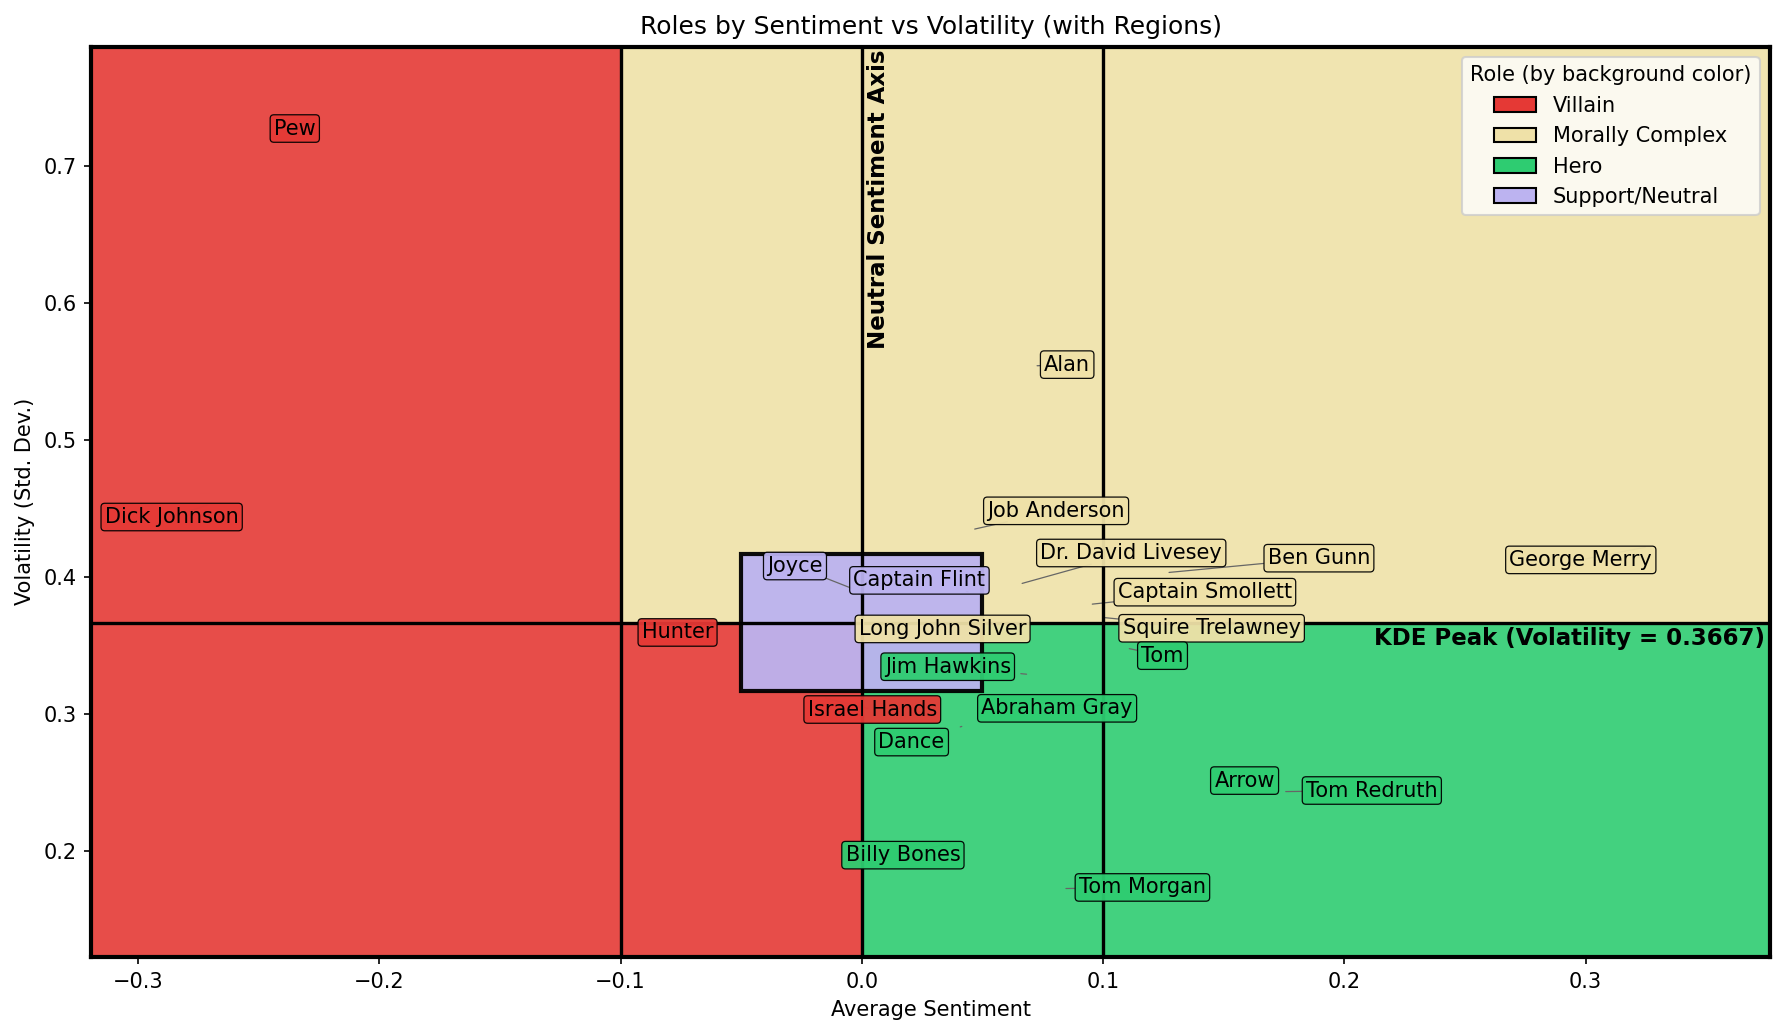

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from adjustText import adjust_text
import numpy as np

def plot_role_map_names_by_role_sync(
    role_df,
    v_star, eps, delta,
    support_half_x=None, support_half_y=None,
    pad_x=0.05, pad_y=0.05,
    line_width=1.6, name_fontsize=10
):
    # background colors
    COLORS = {
        "Villain": "#e53935",
        "Morally Complex": "#efe1a8",
        "Hero": "#2ecc71",
        "Support/Neutral": "#bcb3f0",
    }

    # tie the visual center square to eps unless overridden
    if support_half_x is None: support_half_x = eps
    if support_half_y is None: support_half_y = eps

    xs = role_df["AvgSentiment"].to_numpy()
    ys = role_df["SentimentStdDev"].to_numpy()
    x_min, x_max = xs.min()-pad_x, xs.max()+pad_x
    y_min, y_max = max(0, ys.min()-pad_y), ys.max()+pad_y

    fig, ax = plt.subplots(figsize=(12,7), dpi=150)
    ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
    ax.set_xlabel("Average Sentiment"); ax.set_ylabel("Volatility (Std. Dev.)")
    ax.set_title("Roles by Sentiment vs Volatility (with Regions)")

    # --- background regions (use v_star/eps/delta passed in) ---
    ax.add_patch(Rectangle((x_min, y_min), (-delta-x_min), (v_star-y_min),
                           facecolor=COLORS["Villain"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((x_min, v_star), (-delta-x_min), (y_max-v_star),
                           facecolor=COLORS["Villain"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((-delta, y_min), (0-(-delta)), (v_star-y_min),
                           facecolor=COLORS["Villain"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((-delta, v_star), (0-(-delta)), (y_max-v_star),
                           facecolor=COLORS["Morally Complex"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((0, y_min), (delta-0), (v_star-y_min),
                           facecolor=COLORS["Hero"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((0, v_star), (delta-0), (y_max-v_star),
                           facecolor=COLORS["Morally Complex"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((delta, y_min), (x_max-delta), (v_star-y_min),
                           facecolor=COLORS["Hero"], edgecolor="none", alpha=0.9))
    ax.add_patch(Rectangle((delta, v_star), (x_max-delta), (y_max-v_star),
                           facecolor=COLORS["Morally Complex"], edgecolor="none", alpha=0.9))

    # Center square sized by eps
    ax.add_patch(Rectangle((-support_half_x, v_star-support_half_y),
                           2*support_half_x, 2*support_half_y,
                           facecolor=COLORS["Support/Neutral"], edgecolor="black", linewidth=2, alpha=0.95))

    # dividers + end labels
    ax.axhline(v_star, color="black", linewidth=line_width)
    ax.axvline(-delta, color="black", linewidth=line_width)
    ax.axvline(0.0,    color="black", linewidth=line_width)
    ax.axvline(+delta, color="black", linewidth=line_width)

    ax.text(x_max-0.002, v_star-0.020, f"KDE Peak (Volatility = {v_star:.4f})",
            fontsize=11, fontweight='bold', ha="right", va="bottom")
    ax.text(0.002, y_max-0.002, "Neutral Sentiment Axis",
            fontsize=11, fontweight='bold', ha="left", va="top", rotation=90)

    # role-colored name labels (use precomputed RefinedRole)
    texts = []
    for _, r in role_df.iterrows():
        bg = COLORS[r["RefinedRole"]]
        texts.append(ax.text(
            r["AvgSentiment"], r["SentimentStdDev"], r["Character"],
            fontsize=name_fontsize, ha="center", va="center",
            bbox=dict(boxstyle="round,pad=0.18", fc=bg, ec="black", lw=0.6, alpha=0.95)
        ))
    adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='0.4', lw=0.6))
    

    # legend
    legend_handles = [
        Rectangle((0,0),1,1, facecolor=COLORS["Villain"],         edgecolor="black", label="Villain"),
        Rectangle((0,0),1,1, facecolor=COLORS["Morally Complex"], edgecolor="black", label="Morally Complex"),
        Rectangle((0,0),1,1, facecolor=COLORS["Hero"],            edgecolor="black", label="Hero"),
        Rectangle((0,0),1,1, facecolor=COLORS["Support/Neutral"], edgecolor="black", label="Support/Neutral"),
    ]
    ax.legend(handles=legend_handles, title="Role (by background color)", frameon=True)
    for sp in ax.spines.values(): sp.set_linewidth(2)
    plt.tight_layout(); plt.show()

# ---- call (both table & plot now share EPS/DELTA/VSTAR) ----
plot_role_map_names_by_role_sync(role_df, v_star=VSTAR, eps=EPS, delta=DELTA,
                                 support_half_x=None, support_half_y=None)
